# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from scipy import stats as st

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Загрузка данных

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv', sep = ',')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv', sep = ',')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv', sep = ',')

### Общая информация о данных

In [4]:
def general_info_data(df):
    display(df.head())
    display(df.info())

Характеристики скважины региона 0:

In [5]:
general_info_data(geo_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Характеристики скважины региона 1:

In [6]:
general_info_data(geo_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Характеристики скважины региона 2:

In [7]:
general_info_data(geo_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

### Проверка на дубликаты

In [8]:
geo_0.duplicated().sum()

0

In [9]:
geo_1.duplicated().sum()

0

In [10]:
geo_2.duplicated().sum()

0

### Поиск пропущенных значений

In [11]:
geo_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [12]:
geo_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [13]:
geo_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

**ВЫВОД:**

Датафреймы с характеристиками скважин трех регионов:
- содержат 100000 строк;
- дубликатов нет;
- пропусков нет;
- типы данных в столбцах указаны корректно.

### Исследовательский анализ данных

In [14]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [15]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [16]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


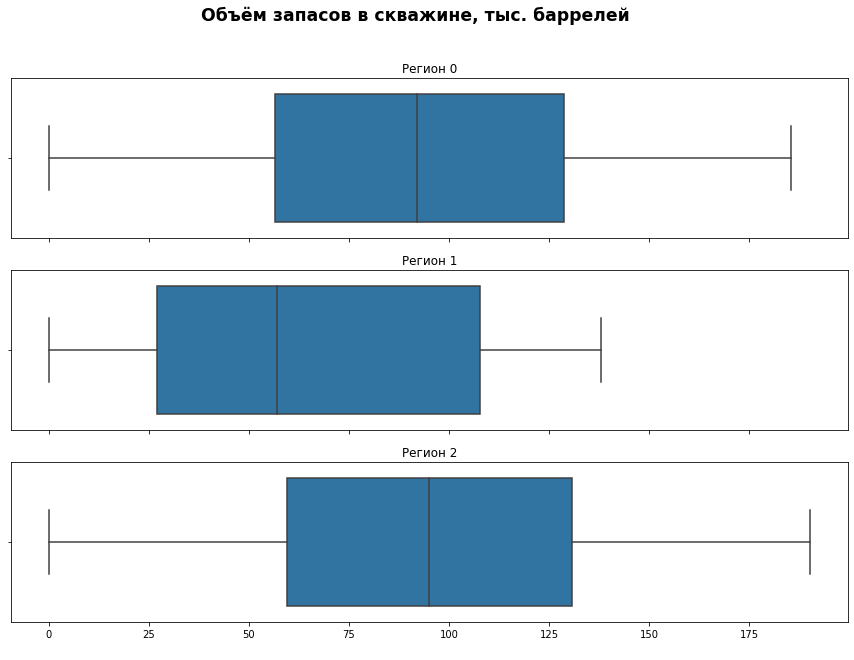

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (15,10))
    
sns.boxplot(data = geo_0, x = 'product', ax=axs[0])
axs[0].set_xlabel(' ')
axs[0].set_title('Регион 0')

sns.boxplot(data = geo_1, x = 'product', ax=axs[1])
axs[1].set_xlabel(' ')
axs[1].set_title('Регион 1')

sns.boxplot(data = geo_2, x = 'product', ax=axs[2])
axs[2].set_xlabel(' ')
axs[2].set_title('Регион 2')

fig.suptitle('Объём запасов в скважине, тыс. баррелей', fontsize = 'xx-large', fontweight = 600)
plt.show()

**ВЫВОД:**

В регионах 0 и 2 запасы объемов в скважине 91.8 тыс.бр и 94.9 тыс.бр соответственно.

В регионе 1 запасы объемов в скважине меньше - 57.1 тыс.бр.

Выбросов в данных нет.

## Обучение и проверка модели

Создадим функцию:

- Разобъем данные на обучающую и валидационную выборки в соотношении 75:25
- Масштабируем данные
- Обучим модель
- Сделаем предсказания на валидационной выборке
- Сохраним предсказания и правильные ответы на валидационной выборке
- Вычислим средний запас предсказанного сырья и RMSE модели


In [18]:
def separation_fit(df):
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    scaler = StandardScaler()
    X_train_scaler = scaler.fit_transform(X_train)
    X_valid_scaler = scaler.transform(X_valid)

    model = LinearRegression()
    model.fit(X_train_scaler, y_train)
    pred_valid = model.predict(X_valid_scaler)
    
    mean_pred_valid = pred_valid.mean()
    rmse = mean_squared_error(y_valid, pred_valid, squared=False)
    
    return pred_valid, y_valid, mean_pred_valid, rmse

In [19]:
pred_valid_0, y_valid_0, mean_pred_valid_0, rmse_0 = separation_fit(geo_0)
print(f'Средний запас предсказанного сырья в регионе 0: {mean_pred_valid_0.round(1)} тыс.бр\nЗначение метрики RMSE: {rmse_0.round(1)}')

Средний запас предсказанного сырья в регионе 0: 92.4 тыс.бр
Значение метрики RMSE: 37.8


In [20]:
pred_valid_1, y_valid_1, mean_pred_valid_1, rmse_1 = separation_fit(geo_1)
print(f'Средний запас предсказанного сырья в регионе 1: {mean_pred_valid_1.round(1)} тыс.бр\nЗначение метрики RMSE: {rmse_1.round(1)}')

Средний запас предсказанного сырья в регионе 1: 68.7 тыс.бр
Значение метрики RMSE: 0.9


In [21]:
pred_valid_2, y_valid_2, mean_pred_valid_2, rmse_2 = separation_fit(geo_2)
print(f'Средний запас предсказанного сырья в регионе 2: {mean_pred_valid_2.round(1)} тыс.бр\nЗначение метрики RMSE: {rmse_2.round(1)}')

Средний запас предсказанного сырья в регионе 2: 94.8 тыс.бр
Значение метрики RMSE: 40.1


**ВЫВОД:**

Наибольший средний запас предсказанного сырья в регионе 2 - 94.8 тыс.бр
Корень среднеквадратичной ошибки при этом 40.1

Близкие результаты показала модель и для региона 0

Наименьший средний запас предсказанного сырья в регионе 1 - 68.7 тыс.бр
Однако, корень среднеквадратичной ошибки 0.9, модель меньше ошибается


## Подготовка к расчёту прибыли

In [22]:
wildcat = 500 
top_wildcat = 200
budget = 10**10
income = 450000
losses_max = 2.5

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [23]:
volume_raw = budget/(top_wildcat*income)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {volume_raw} тыс.бр')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111 тыс.бр


**ВЫВОД:**

Средний запас предсказанного сырья во всех регионах ниже 111.1 тыс.бр. Для безубыточной разработки новых скважин выберем скважины с запасом сырья выше 111 тыс.бр.


## Расчёт прибыли и рисков 

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- Выберем скважины с максимальными значениями предсказаний
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
- Рассчитаем прибыль для полученного объёма сырья

In [24]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (income * selected.sum() - budget)

In [25]:
def res_ind_ser(y_true, y_pred):
    y_true = y_true.reset_index(drop=True)
    y_pred = pd.Series(y_pred)
    return y_true, y_pred

In [26]:
state = np.random.RandomState(12345)

In [27]:
bootstrap_samples = 1000

In [28]:
def make_bootstrap(target, probabilities):
    
    target, probabilities = res_ind_ser(target, probabilities)
    
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=wildcat, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
    
        values.append(revenue(target_subsample, probs_subsample, top_wildcat))

    values = pd.Series(values)
    
    mean = values.mean()
    interval = (values.quantile(0.025), values.quantile(0.975))
    loss_probability = values[values < 0].count() / values.count()
    
    print(f'Средняя прибыль в регионе 0: {mean/10**6:.2f} млн. руб')
    print('Доверительный интервал (95%)', interval)    
    print('Вероятность убытка региона : {:.2%}'.format(loss_probability))  

In [29]:
print('\033[1mПрогноз по региону 0:\033[0m\n')
make_bootstrap(y_valid_0, pred_valid_0)

print('\n\n\033[1mПрогноз по региону 1:\033[0m\n')
make_bootstrap(y_valid_1, pred_valid_1)

print('\n\n\033[1mПрогноз по региону 2:\033[0m\n')
make_bootstrap(y_valid_2, pred_valid_2)

Прогноз по региону 0:

Средняя прибыль в регионе 0: 435.93 млн. руб
Доверительный интервал (95%) (-116231612.77720818, 966504180.707376)
Вероятность убытка региона : 6.10%


Прогноз по региону 1:

Средняя прибыль в регионе 0: 498.57 млн. руб
Доверительный интервал (95%) (75315573.08898354, 911503695.0245577)
Вероятность убытка региона : 1.00%


Прогноз по региону 2:

Средняя прибыль в регионе 0: 412.67 млн. руб
Доверительный интервал (95%) (-158939515.7636048, 978191201.7001915)
Вероятность убытка региона : 7.00%


**ВЫВОД:**

Наиболее перспективным для разработки является регион 1: 
- прибыль 498.57 млн. руб, 
- вероятность убытка 1%
- средний запас предсказанного сырья: 68.7 тыс.бр